# Performance comparison of JAX nested derivatives and Taylor-mode differentiation

In [1]:
import jax
from jax import numpy as jnp
from jax.experimental import jet
import time
import numpy as np

from utils.g_matrix import Gmat
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

As an example, we compute derivatives of a specific element in the kinetic energy $G$-matrix of the six-atomic molecule formaldehyde ($\text{H}_2\text{CO}$) with respect to one of its internal coordinates. The computation of the $G$-matrix involves operations such as matrix multiplication, matrix inversion, and Jacobian evaluations, i.e.,

$$
G = \left[\sum_{i=1}^N\sum_{\alpha=x,y,z}m_i\frac{\partial r_{i\alpha}}{\partial q_\lambda}\frac{\partial r_{i\alpha}}{\partial q_\mu}\right]^{-1},
$$

where $r_{i\alpha}$ are $\alpha=x,y,z$ Cartesian coordinates of the $i$-th atom ($i=1..N$) and $q_\lambda$ ($\lambda=1..3N-6$) are the internal vibrational coordinates, such as valence interatomic bond distances and angles (see implementation of `Gmat` in [utils/g_matrix.py](utils/g_matrix.py)).

In [2]:
x0 = jnp.array([1.2, 1.1, 1.1, 2.13, 2.13, jnp.pi])

# Function, computing [5, 5] element of G-matrix as a function
# of 5-th coordinate, with other coordinates fixed as `x0`
Gmat_x5_55 = lambda x5: Gmat(jnp.where(jnp.arange(6) == 5, x5, x0))[5, 5]

# reference value for 5-th coordinate
x5 = jnp.pi

# maximal expansion order
max_order = 8

First, compute high-order derivatives by recursively applying `jax.grad`

In [3]:
time_nested = np.zeros(max_order + 1)

deriv_func = [Gmat_x5_55]
for i in range(1, max_order + 1):
    start = time.time()
    deriv_func.append(jax.grad(deriv_func[i - 1]))
    end = time.time()
    time_nested[i] = end - start

deriv_val_nested = np.zeros(max_order + 1)

deriv_val_nested[0] = deriv_func[0](x5)
for i in range(1, max_order + 1):
    start = time.time()
    deriv_val_nested[i] = deriv_func[i](x5)
    end = time.time()
    time_nested[i] += end - start

# cumulative time for expansion order ranging from 1 to max_order
time_nested = np.cumsum(time_nested)

np.savez('_nested.npz', time=time_nested, val=deriv_val_nested)

Now, compute derivatives using Taylor polynomials, as implemented in `jax.experimental.jet`

In [4]:
time_taylor = np.zeros(max_order + 1)

# repeat expansions for different truncation orders (for timing only)
for i in range(1, max_order + 1):
    deg = [0.0] * i
    deg[0] = 1.0
    start = time.time()
    c0, c = jet.jet(Gmat_x5_55, (x5,), (deg,))
    end = time.time()
    time_taylor[i] = end - start

deriv_val_taylor = np.array([c0] + c)

np.savez('_taylor.npz', time=time_taylor, val=deriv_val_taylor)

Compare derivative values

In [5]:
nested = np.load('_nested.npz')
time_nested = nested['time']
deriv_val_nested = nested['val']

taylor = np.load('_taylor.npz')
time_taylor = taylor['time']
deriv_val_taylor = taylor['val']

print("Order", "Nested", "      Taylor", "      difference")
for i, (d_nes, d_tay) in enumerate(zip(deriv_val_nested, deriv_val_taylor)):
    print(f"{i}   {d_nes:12.8f} {d_tay:12.8f} {(d_nes - d_tay):12.8f}")

Order Nested       Taylor       difference
0     3.19739834   3.19739834   0.00000000
1     0.00000000  -0.00000000   0.00000000
2    -0.45748325  -0.45748325  -0.00000000
3    -0.00000000   0.00000000  -0.00000000
4     0.45748325   0.45748325   0.00000000
5     0.00000000  -0.00000000   0.00000000
6    -0.45748325  -0.45748325  -0.00000000
7    -0.00000000   0.00000000  -0.00000000
8     0.45748325   0.45748325   0.00000000


Plot time scaling

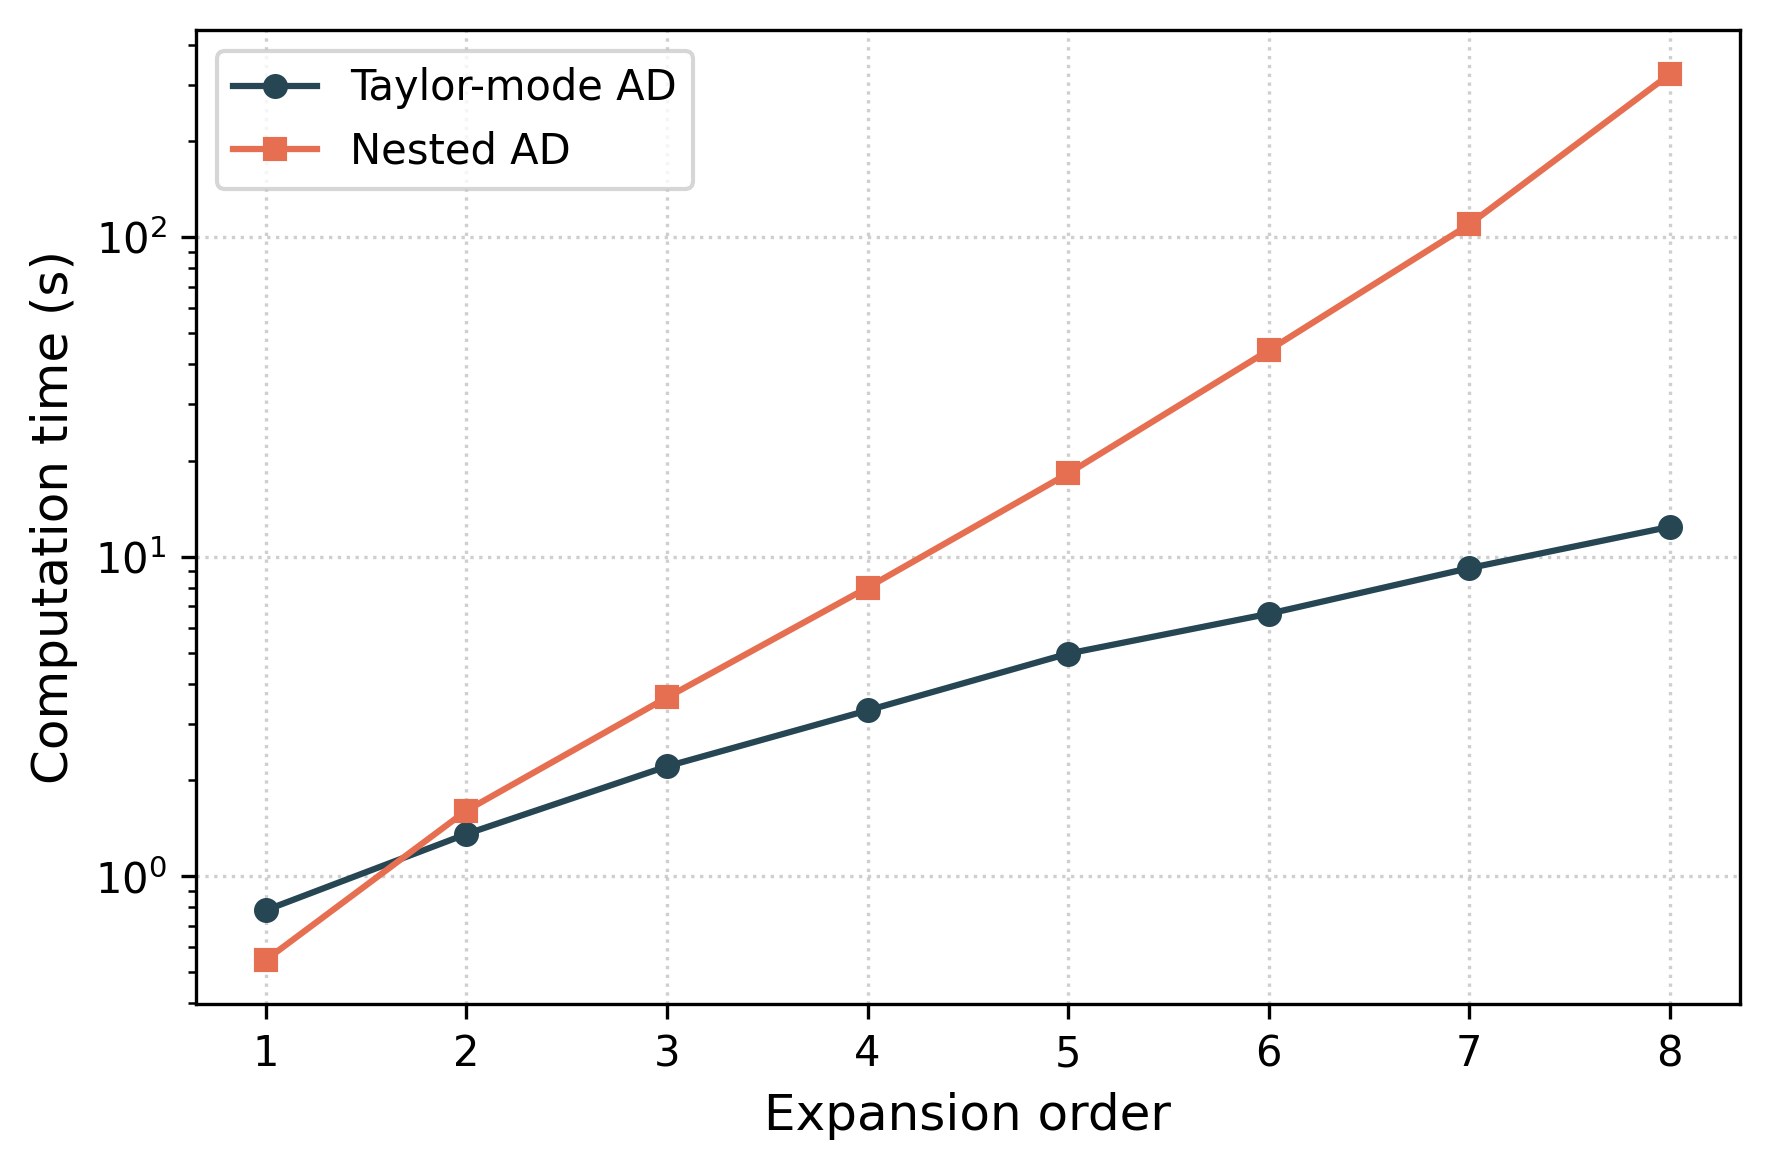

In [6]:
plt.figure(figsize=(6, 4), dpi=300)

plt.plot(
    np.arange(1, max_order + 1),
    time_taylor[1:],
    label="Taylor-mode AD",
    marker="o",
    linestyle="-",
    linewidth="1.5",
    markersize=5,
    color='#264653',
)
plt.plot(
    np.arange(1, max_order + 1),
    time_nested[1:],
    label="Nested AD",
    marker="s",
    linestyle="-",
    linewidth="1.5",
    markersize=5,
    color='#e76f51',
)

plt.xlabel('Expansion order', fontsize=12)
plt.ylabel('Computation time (s)', fontsize=12)
plt.yscale('log')

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()